
## Title: Concrete Wall Crack Detection



Description: Training an image classifier from to detect cracks on concrete walls.


In [1]:
## Setup

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import os

folder_path = "/Users/nicolelobo/Downloads/Concrete-Wall-Crack-Detection-main"
print("Folder exists:", os.path.exists(folder_path))


Folder exists: True


In [3]:
import os
import tensorflow as tf

dataset_path = "/Users/nicolelobo/Downloads/Concrete-Wall-Crack-Detection-main/concrete_data"

num_skipped = 0

# Iterate through train, test, and valid directories
for dataset_type in ("train", "test", "valid"):
    dataset_folder = os.path.join(dataset_path, dataset_type)

    if not os.path.exists(dataset_folder):
        print(f"Error: Folder '{dataset_folder}' not found!")
        continue  # Skip if the folder doesn't exist

    # Iterate through Negative and Positive folders inside each dataset type
    for folder_name in ("Negative", "Positive"):
        folder_path = os.path.join(dataset_folder, folder_name)

        if not os.path.exists(folder_path):
            print(f"Error: Folder '{folder_path}' not found!")
            continue  # Skip if the folder doesn't exist

        for fname in os.listdir(folder_path):
            fpath = os.path.join(folder_path, fname)
            try:
                with open(fpath, "rb") as fobj:
                    is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
            except Exception as e:
                print(f"Error reading {fpath}: {e}")
                is_jfif = False  # Mark as corrupted if an error occurs

            if not is_jfif:
                num_skipped += 1
                os.remove(fpath)  # Delete corrupted image
                print(f"Deleted corrupted image: {fpath}")

print(f"Deleted {num_skipped} images")


Deleted 0 images


In [4]:
# Define the missing variables
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,  # Ensure this is set correctly
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,  # Ensure this is set correctly
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 40000 files belonging to 3 classes.
Using 32000 files for training.
Found 40000 files belonging to 3 classes.
Using 8000 files for validation.


2025-03-24 22:27:16.749418: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


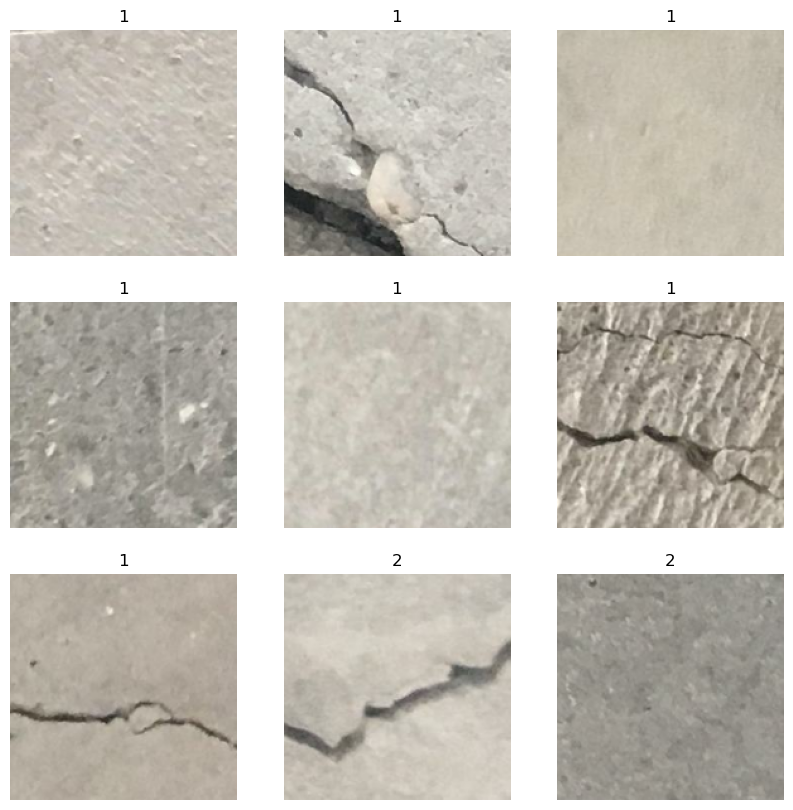

In [5]:
# Visualizing the data
# The images labelled 1 contains crack 
# and the ones labelled 0 are smooth
    
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)


2025-03-24 22:27:25.259222: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


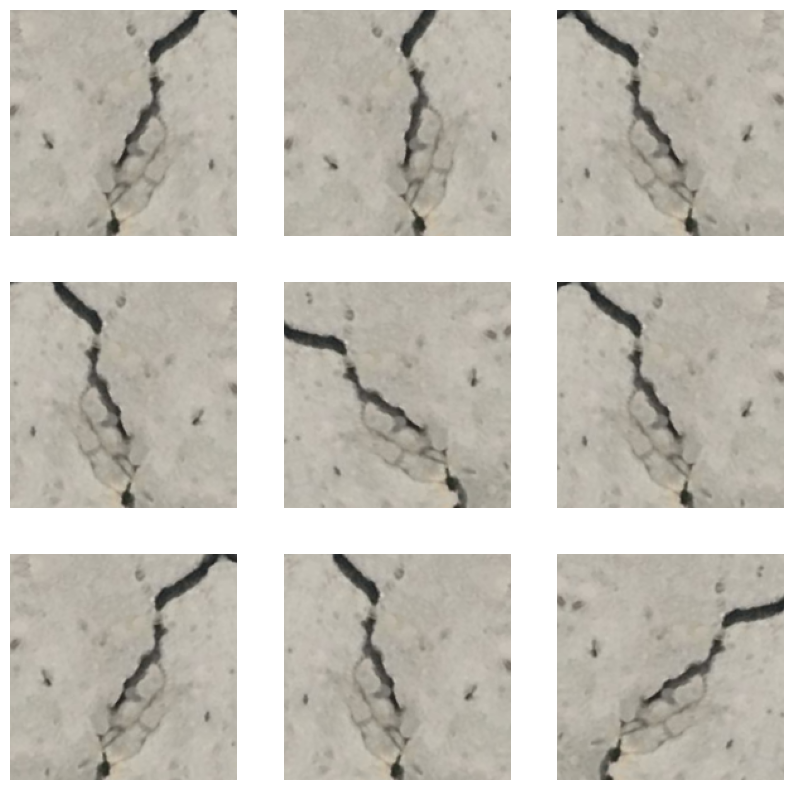

In [7]:
# Let's visualizing the augmented samples

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [8]:
# Configure dataset for performance

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


In [9]:
# Define data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])


In [15]:
# Define the model
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

#  Create the model
model = make_model(input_shape=image_size + (3,), num_classes=2)

# Visualize the model architecture
keras.utils.plot_model(model, show_shapes=True)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

#  Train the model
epochs = 10
model.fit(train_ds, validation_data=val_ds, epochs=epochs)

#  Save the model
model.save("concrete_crack_detection_model.h5")

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4552s 5s/step - accuracy: 0.9784 - loss: 0.0593 - val_accuracy: 0.9864 - val_loss: 0.0475
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4706s 5s/step - accuracy: 0.9949 - loss: 0.0212 - val_accuracy: 0.9976 - val_loss: 0.0088
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4787s 5s/step - accuracy: 0.9961 - loss: 0.0150 - val_accuracy: 0.9919 - val_loss: 0.0238
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5080s 5s/step - accuracy: 0.9950 - loss: 0.0169 - val_accuracy: 0.9848 - val_loss: 0.0509
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4969s 5s/step - accuracy: 0.9957 - loss: 0.0160 - val_accuracy: 0.9987 - val_loss: 0.0054
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4894s 5s/step - accuracy: 0.9957 - loss: 0.0143 - val_accuracy: 0.9986 - val_loss: 0.0063
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4212s 4s/step - accuracy: 0.9967 - loss: 0.0106 - val_accuracy: 0.978

In [75]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [57]:
pip install opencv-python


Note: you may need to restart the kernel to use updated packages.


In [58]:
pip install opencv-python-headless


Note: you may need to restart the kernel to use updated packages.


In [57]:
import cv2
import numpy as np

def detect_cracks(image_path, output_path):
    # Load image
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Step 1: Detect Only Cracks Using Edge Detection
    edges = cv2.Canny(gray, 50, 200)  # Strong edges

    # Step 2: Morphological Thinning to Keep Only Cracks
    kernel = np.ones((2, 2), np.uint8)
    thin_cracks = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=1)  # Thinning

    # Step 3: Find Crack Contours & Filter Only Thin, Long Cracks
    contours, _ = cv2.findContours(thin_cracks, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        # Ensure only long, thin cracks are detected (filter out blocks)
        aspect_ratio = w / float(h)
        area = cv2.contourArea(contour)

        if 0.1 < aspect_ratio < 10 and area < 5000:  # Filter non-crack regions
            cv2.drawContours(image, [contour], -1, (0, 255, 0), 1)  # Draw cracks in green

    # Save output
    cv2.imwrite(output_path, image)
    print(f"Processed image saved as {output_path}")

# Example usage
detect_cracks(
    '/Users/nicolelobo/Downloads/Concrete-Wall-Crack-Detection-main/input/19755.jpg', 
    '/Users/nicolelobo/Downloads/Concrete-Wall-Crack-Detection-main/output/19755.jpg'
)


Processed image saved as /Users/nicolelobo/Downloads/Concrete-Wall-Crack-Detection-main/output/19755.jpg


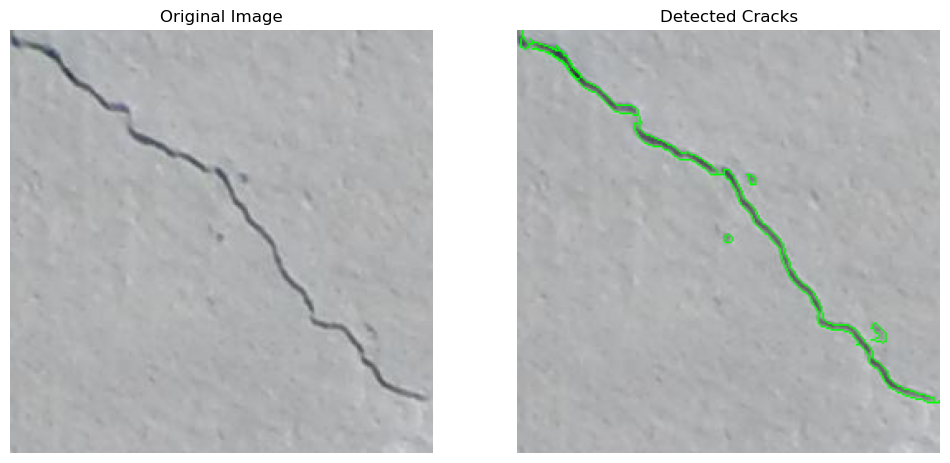

In [58]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_cracks(image_path):
    # Load image
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Step 1: Detect Only Cracks Using Edge Detection
    edges = cv2.Canny(gray, 50, 200)  # Strong edges

    # Step 2: Morphological Thinning to Keep Only Cracks
    kernel = np.ones((2, 2), np.uint8)
    thin_cracks = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=1)  # Thinning

    # Step 3: Find Crack Contours & Filter Only Thin, Long Cracks
    contours, _ = cv2.findContours(thin_cracks, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        # Ensure only long, thin cracks are detected (filter out blocks)
        aspect_ratio = w / float(h)
        area = cv2.contourArea(contour)

        if 0.1 < aspect_ratio < 10 and area < 5000:  # Filter non-crack regions
            cv2.drawContours(image, [contour], -1, (0, 255, 0), 1)  # Draw cracks in green

    # Convert images to RGB for Matplotlib display
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Processed image
    original_rgb = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)  # Original image

    # Display input (original) and output (processed) images side by side
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Show original image
    ax[0].imshow(original_rgb)
    ax[0].axis("off")
    ax[0].set_title("Original Image")

    # Show processed image
    ax[1].imshow(image_rgb)
    ax[1].axis("off")
    ax[1].set_title("Detected Cracks")

    plt.show()

# Example usage
detect_cracks('/Users/nicolelobo/Downloads/Concrete-Wall-Crack-Detection-main/input/7001-21.jpg')


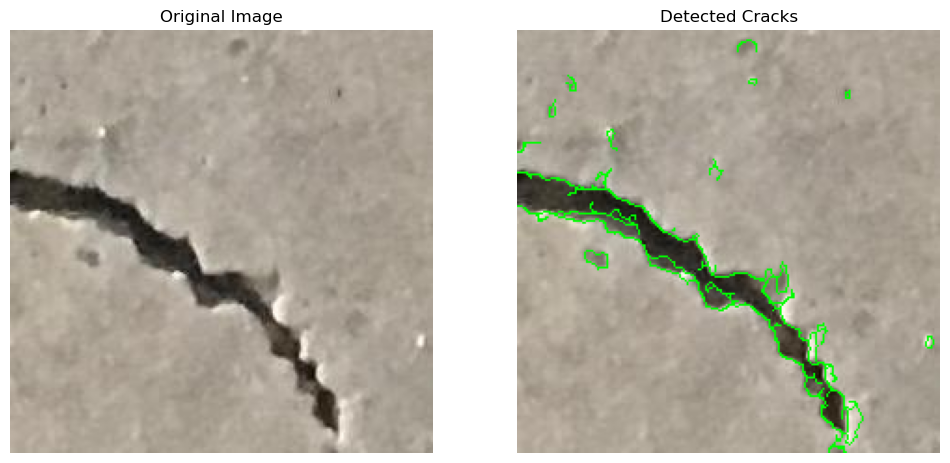

In [60]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_cracks(image_path):
    # Load image
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Step 1: Detect Only Cracks Using Edge Detection
    edges = cv2.Canny(gray, 50, 200)  # Strong edges

    # Step 2: Morphological Thinning to Keep Only Cracks
    kernel = np.ones((2, 2), np.uint8)
    thin_cracks = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=1)  # Thinning

    # Step 3: Find Crack Contours & Filter Only Thin, Long Cracks
    contours, _ = cv2.findContours(thin_cracks, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        # Ensure only long, thin cracks are detected (filter out blocks)
        aspect_ratio = w / float(h)
        area = cv2.contourArea(contour)

        if 0.1 < aspect_ratio < 10 and area < 5000:  # Filter non-crack regions
            cv2.drawContours(image, [contour], -1, (0, 255, 0), 1)  # Draw cracks in green

    # Convert images to RGB for Matplotlib display
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Processed image
    original_rgb = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)  # Original image

    # Display input (original) and output (processed) images side by side
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Show original image
    ax[0].imshow(original_rgb)
    ax[0].axis("off")
    ax[0].set_title("Original Image")

    # Show processed image
    ax[1].imshow(image_rgb)
    ax[1].axis("off")
    ax[1].set_title("Detected Cracks")

    plt.show()

# Example usage
detect_cracks('/Users/nicolelobo/Downloads/Concrete-Wall-Crack-Detection-main/input/19755.jpg')


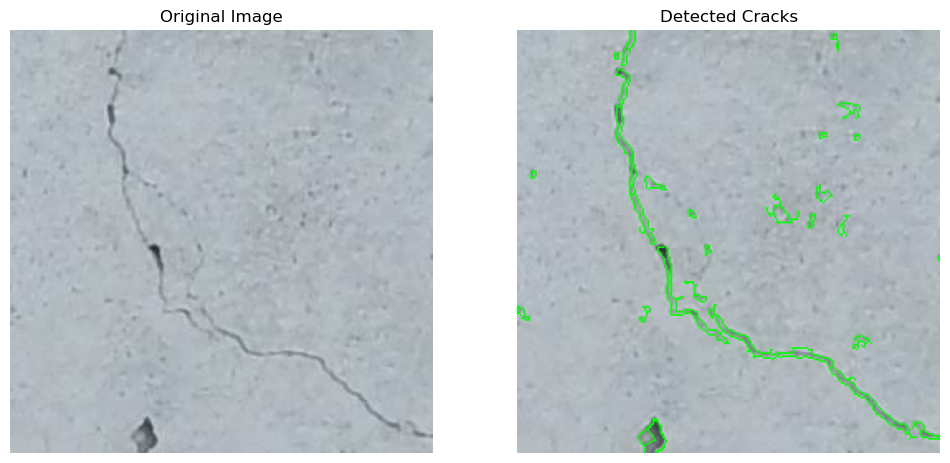

In [61]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_cracks(image_path):
    # Load image
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Step 1: Detect Only Cracks Using Edge Detection
    edges = cv2.Canny(gray, 50, 200)  # Strong edges

    # Step 2: Morphological Thinning to Keep Only Cracks
    kernel = np.ones((2, 2), np.uint8)
    thin_cracks = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=1)  # Thinning

    # Step 3: Find Crack Contours & Filter Only Thin, Long Cracks
    contours, _ = cv2.findContours(thin_cracks, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        # Ensure only long, thin cracks are detected (filter out blocks)
        aspect_ratio = w / float(h)
        area = cv2.contourArea(contour)

        if 0.1 < aspect_ratio < 10 and area < 5000:  # Filter non-crack regions
            cv2.drawContours(image, [contour], -1, (0, 255, 0), 1)  # Draw cracks in green

    # Convert images to RGB for Matplotlib display
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Processed image
    original_rgb = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)  # Original image

    # Display input (original) and output (processed) images side by side
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Show original image
    ax[0].imshow(original_rgb)
    ax[0].axis("off")
    ax[0].set_title("Original Image")

    # Show processed image
    ax[1].imshow(image_rgb)
    ax[1].axis("off")
    ax[1].set_title("Detected Cracks")

    plt.show()

# Example usage
detect_cracks('/Users/nicolelobo/Downloads/Concrete-Wall-Crack-Detection-main/input/7069-138.jpg')


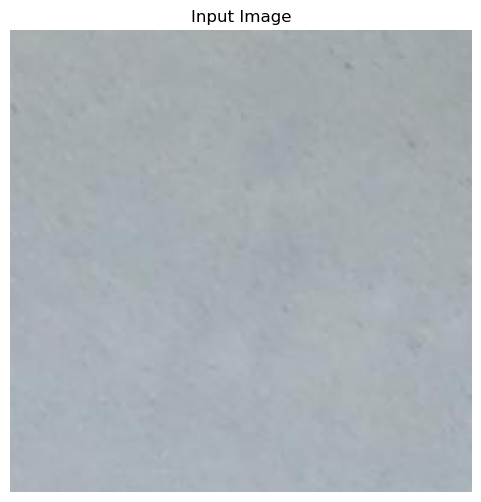

No Crack Detected


In [66]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_cracks(image_path):
    # Load image
    image = cv2.imread(image_path)
    original_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert for display
    
    # Display the input image before processing
    plt.figure(figsize=(6, 6))
    plt.imshow(original_rgb)
    plt.axis("off")
    plt.title("Input Image")
    plt.show()
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Step 1: Detect Only Cracks Using Edge Detection
    edges = cv2.Canny(gray, 50, 200)  # Strong edges

    # Step 2: Morphological Thinning to Keep Only Cracks
    kernel = np.ones((2, 2), np.uint8)
    thin_cracks = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=1)  # Thinning

    # Step 3: Find Crack Contours & Filter Only Thin, Long Cracks
    contours, _ = cv2.findContours(thin_cracks, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # If no contours (cracks) found, print message and exit function
    if not contours:
        print("No Crack Detected")
        return

    # Draw detected cracks
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        # Ensure only long, thin cracks are detected (filter out blocks)
        aspect_ratio = w / float(h)
        area = cv2.contourArea(contour)

        if 0.1 < aspect_ratio < 10 and area < 5000:  # Filter non-crack regions
            cv2.drawContours(image, [contour], -1, (0, 255, 0), 1)  # Draw cracks in green

    # Convert processed image to RGB for Matplotlib display
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display input (original) and output (processed) images side by side
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(original_rgb)
    ax[0].axis("off")
    ax[0].set_title("Original Image")

    ax[1].imshow(image_rgb)
    ax[1].axis("off")
    ax[1].set_title("Detected Cracks")

    plt.show()

# Example usage
detect_cracks('/Users/nicolelobo/Downloads/Concrete-Wall-Crack-Detection-main/input/7069-2.jpg')
